## Analyze Dataset Performance

As described in the README's RIP example scripts, the user can set `--debug_collect_dataset_stats=True` and cache statistics and performance over the training and validation datasets to file.

This script provides some analysis utilities for plotting and understanding a model's performance on various subsets of the data.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict
import numpy as np

In [17]:
# full_model_name takes a format such as rip-bc-k_3-plan_ma-scene_ma
# for a RIP ensemble with the Behavioral Cloning backbone, 3 ensemble members, and
# model averaging (mean) aggregation over per-plan and per-scene confidence scores.
# For more details, see `sdc.oatomobile.torch.baselines.robust_imitative_planning.py`.

dir_metadata_cache = '/path/to/metadata_cache/full_model_name'

In [18]:
with open(os.path.join(dir_metadata_cache, 'request.tsv')) as f:
    request_df = pd.read_csv(f, sep='\t')
    
with open(os.path.join(dir_metadata_cache, 'scene.tsv')) as f:
    scene_df = pd.read_csv(f, sep='\t')

In [19]:
# Join prediction_request_df and scene_df on scene_id
merged_df = pd.merge(request_df, scene_df, on=['scene_ids'])

In [76]:
def load_merged_df(metadata_cache_path):
    with open(os.path.join(metadata_cache_path, 'request.tsv')) as f:
        request_df = pd.read_csv(f, sep='\t')
    
    with open(os.path.join(metadata_cache_path, 'scene.tsv')) as f:
        scene_df = pd.read_csv(f, sep='\t')
        
    return pd.merge(request_df, scene_df, on=['scene_ids'])

In [20]:
merged_df.head()

,pred_request_confidence_scores,request_ids,kMoveLeft,kMoveRight,kMoveForward,kMoveBack,kAcceleration,kDeceleration,kUniform,kStopping,...,track__TelAviv,sun_phase__kAstronomicalNight,sun_phase__kTwilight,sun_phase__kDaylight,precipitation__kNoPrecipitation,precipitation__kRain,precipitation__kSleet,precipitation__kSnow,dataset_key_y,run_datetime_y
0,-20.112260,224,False,False,False,False,False,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:56:07.097614
1,-30.670252,225,False,False,False,False,True,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:56:07.097614
2,-63.920956,227,False,False,False,False,True,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:56:07.097614
3,-63.777767,234,False,False,False,False,False,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:56:07.097614
4,38.987762,240,False,False,False,False,False,False,True,True,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:56:07.097614


### Basic Stats from Request DataFrame

In [21]:
from pprint import pprint
from sdc.analyze_metadata import get_all_paper_results

paper_results = get_all_paper_results(request_df, 'weightedADE')
pprint(paper_results)

{'f95': 0.79834816654175,
 'f_auc': 0.5538332818605451,
 'f_ret_curve': array([0.00000000e+00, 2.76797837e-06, 5.53594907e-06, ...,
       8.23805191e-01, 8.23804722e-01, 8.23804252e-01]),
 'minADE': 0.7987038581149104,
 'minFDE': 1.7029657141610124,
 'r_auc': 0.48477144777971154,
 'ret_curve': array([1.05535954e+00, 1.05535100e+00, 1.05534955e+00, ...,
       1.05256067e-06, 7.23642239e-07, 0.00000000e+00]),
 'weightedADE': 1.0553595437649963,
 'weightedFDE': 2.3104941918293322}


In [22]:
moscow_val_rows = merged_df[merged_df['dataset_key_y'] == 'moscow__validation']
ood_val_rows = merged_df[merged_df['dataset_key_y'] == 'ood__validation']

In [23]:
# Average confidence on the Moscow and OOD validation sets, respectively
moscow_val_rows.pred_request_confidence_scores.mean(), ood_val_rows.pred_request_confidence_scores.mean()

(-208.56756436238473, -162.63439807622203)

In [24]:
# Average minADE on the same validation sets
moscow_val_rows['minADE'].mean(), ood_val_rows['minADE'].mean()

(0.765964637294999, 0.8886942426041035)

In [25]:
list(merged_df.columns)

['pred_request_confidence_scores',
 'request_ids',
 'kMoveLeft',
 'kMoveRight',
 'kMoveForward',
 'kMoveBack',
 'kAcceleration',
 'kDeceleration',
 'kUniform',
 'kStopping',
 'kStarting',
 'kStationary',
 'top1ADE',
 'top1FDE',
 'minADE',
 'minFDE',
 'avgADE',
 'avgFDE',
 'weightedADE',
 'weightedFDE',
 'scene_ids',
 'dataset_key_x',
 'run_datetime_x',
 'num_vehicles',
 'day_time__kNight',
 'day_time__kMorning',
 'day_time__kAfternoon',
 'day_time__kEvening',
 'season__kWinter',
 'season__kSpring',
 'season__kSummer',
 'season__kAutumn',
 'track__Moscow',
 'track__Skolkovo',
 'track__Innopolis',
 'track__AnnArbor',
 'track__Modiin',
 'track__TelAviv',
 'sun_phase__kAstronomicalNight',
 'sun_phase__kTwilight',
 'sun_phase__kDaylight',
 'precipitation__kNoPrecipitation',
 'precipitation__kRain',
 'precipitation__kSleet',
 'precipitation__kSnow',
 'dataset_key_y',
 'run_datetime_y']

### Fbeta Retention Plots

In [26]:
import numpy as np

# Get an idea of a reasonable cutoff for an "acceptable prediction" on our metric of choice.
# We achieve a weightedADE near 1, and hence fix the threshold to 1 for our metrics.
error_col = 'weightedADE'
np.mean(moscow_val_rows['weightedADE'])

1.0178234481798207

(array([8.700e+02, 4.470e+03, 6.272e+03, 6.556e+03, 6.800e+03, 6.962e+03,
        7.372e+03, 7.849e+03, 8.254e+03, 8.369e+03, 8.434e+03, 8.678e+03,
        8.521e+03, 8.228e+03, 7.954e+03, 7.633e+03, 7.140e+03, 6.793e+03,
        6.528e+03, 6.121e+03, 6.026e+03, 5.373e+03, 5.253e+03, 4.916e+03,
        4.588e+03, 4.232e+03, 3.936e+03, 3.799e+03, 3.625e+03, 3.372e+03,
        3.189e+03, 2.987e+03, 2.888e+03, 2.745e+03, 2.598e+03, 2.545e+03,
        2.446e+03, 2.318e+03, 2.275e+03, 2.105e+03, 2.046e+03, 2.078e+03,
        1.956e+03, 1.934e+03, 1.865e+03, 1.808e+03, 1.776e+03, 1.807e+03,
        1.706e+03, 1.654e+03, 1.683e+03, 1.617e+03, 1.572e+03, 1.587e+03,
        1.451e+03, 1.513e+03, 1.470e+03, 1.381e+03, 1.430e+03, 1.475e+03,
        1.356e+03, 1.396e+03, 1.361e+03, 1.323e+03, 1.304e+03, 1.272e+03,
        1.228e+03, 1.265e+03, 1.215e+03, 1.252e+03, 1.183e+03, 1.205e+03,
        1.203e+03, 1.173e+03, 1.171e+03, 1.174e+03, 1.121e+03, 1.148e+03,
        1.112e+03, 1.115e+03, 1.107e+0

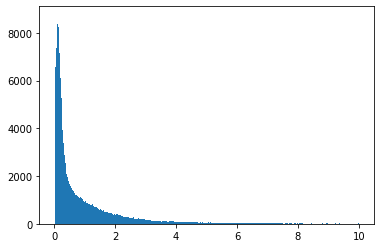

In [27]:
# Plot histogram of weightedADE values for the Moscow development dataset, excluding outliers >= 10
plt.hist(moscow_val_rows['weightedADE'][moscow_val_rows['weightedADE'] < 10], bins=1000)

In [33]:
from sdc.analyze_metadata import f1_retention_baseline_results

errors = merged_df['weightedADE'].to_numpy()
uncertainty_scores = -(merged_df['pred_request_confidence_scores'].to_numpy())
f1_results_dict = f1_retention_baseline_results(errors=errors, uncertainty_scores=uncertainty_scores)

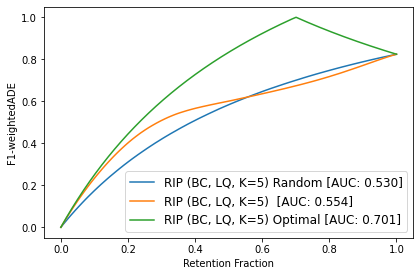

In [34]:
from plot_retention_curves import plot_fbeta_retention_curve_with_baselines

fig = plot_fbeta_retention_curve_with_baselines(
    results_dict=f1_results_dict, model_key='BC, LQ, K=5', metric_name='weightedADE')

### Dataset Structure Analysis
Consider on which splits of the data the model performs better.

<Figure size 1440x720 with 0 Axes>

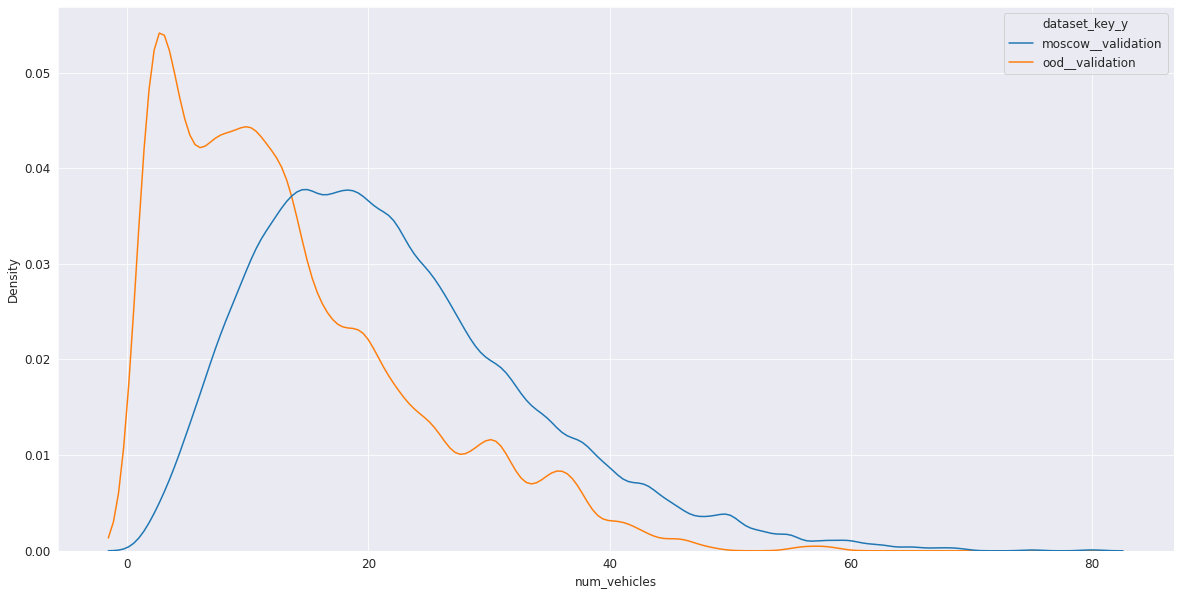

<Figure size 1440x720 with 0 Axes>

In [40]:
# Distribution of number of vehicles in each dataset
plt.rcParams["figure.figsize"] = (20,10)

sns.kdeplot(
    data=merged_df, x="num_vehicles", hue="dataset_key_y",
    common_norm=False, common_grid=True)
plt.figure(figsize=(20,10))

### Tag Groups

In [41]:
TRAJECTORY_TAGS = [
 'kMoveLeft',
 'kMoveRight',
 'kMoveForward',
 'kMoveBack',
 'kAcceleration',
 'kDeceleration',
 'kUniform',
 'kStopping',
 'kStarting',
 'kStationary'
]
TIMES_OF_DAY = [
 'day_time__kNight',
 'day_time__kMorning',
 'day_time__kAfternoon',
 'day_time__kEvening',
]
SEASONS = [
 'season__kWinter',
 'season__kSpring',
 'season__kSummer',
 'season__kAutumn',
]
CITY = [
 'track__Moscow',
 'track__Skolkovo',
 'track__Innopolis',
 'track__AnnArbor',
 'track__Modiin',
 'track__TelAviv'
]

In [42]:
# For each dataset, bucket a metric by percentile (e.g., into deciles). 
# Plot the distribution of various tags within each bucket.

def tag_heatmap(metric, tags, dataset_key, n_buckets=10, bucket_normalize=True):
    dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
    
    # Bucket rows based on metric column
    dataset_df[f'{metric}_decile'] = pd.qcut(dataset_df[metric], q=n_buckets, labels=range(n_buckets))
    print(f'Min {metric} in deciles:')
    print(dataset_df.groupby(f'{metric}_decile')[metric].mean())
    print(dataset_df.groupby(f'{metric}_decile')[metric].count())
    
    # Group by buckets
    percentiles = [val / 10 for val in range(n_buckets)]
    values = np.zeros((len(tags), len(percentiles)))
    
    dataset_n_rows = len(dataset_df)
    
    if bucket_normalize:
        for j, perc in enumerate(range(n_buckets)):
            perc_df = dataset_df[dataset_df[f'{metric}_decile'] == perc]
            total_perc_rows = len(perc_df)
            print(total_perc_rows)
            for i, tag in enumerate(tags):
                tag_df = perc_df[perc_df[tag] == 1]
                values[i, j] = len(tag_df) / total_perc_rows
    else:
        for i, tag in enumerate(tags):
            tag_df = dataset_df[dataset_df[tag] == 1]
            counts = tag_df.value_counts(subset=[f'{metric}_decile']).to_numpy()[::-1]
            norm_counts = counts / counts.sum()
            values[i, :] = norm_counts

    values = np.stack(values)
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap="YlGn")
    cbar = ax.figure.colorbar(im, ax=ax)
    
    # We want to show all the ticks
    ax.set_xticks(np.arange(len(percentiles)))
    ax.set_yticks(np.arange(len(tags)))
    
    # and label them with the respective list entries
    ax.set_xticklabels(percentiles)
    ax.set_yticklabels(tags)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(tags)):
        for j in range(len(percentiles)):
            text = ax.text(j, i, f'{values[i, j]:.2}',
                           ha="center", va="center", color="black")

    if bucket_normalize:
        ax.set_title(f"Proportion of {metric} Decile with Given Tag")
    else:
        ax.set_title(f'Proportion of Given Tag Falling in Each {metric} Decile')
        
    fig.tight_layout()
    plt.show()

<ipython-input-42-f9614de60dcd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[f'{metric}_decile'] = pd.qcut(dataset_df[metric], q=n_buckets, labels=range(n_buckets))
<ipython-input-42-f9614de60dcd>:31: RuntimeWarning: invalid value encountered in true_divide
  norm_counts = counts / counts.sum()


Min minADE in deciles:
minADE_decile
0    0.047726
1    0.073343
2    0.091014
3    0.110095
4    0.135337
5    0.177104
6    0.280657
7    0.688162
8    1.664772
9    5.618604
Name: minADE, dtype: float64
minADE_decile
0    5567
1    5567
2    5567
3    5567
4    5567
5    5566
6    5567
7    5567
8    5567
9    5567
Name: minADE, dtype: int64


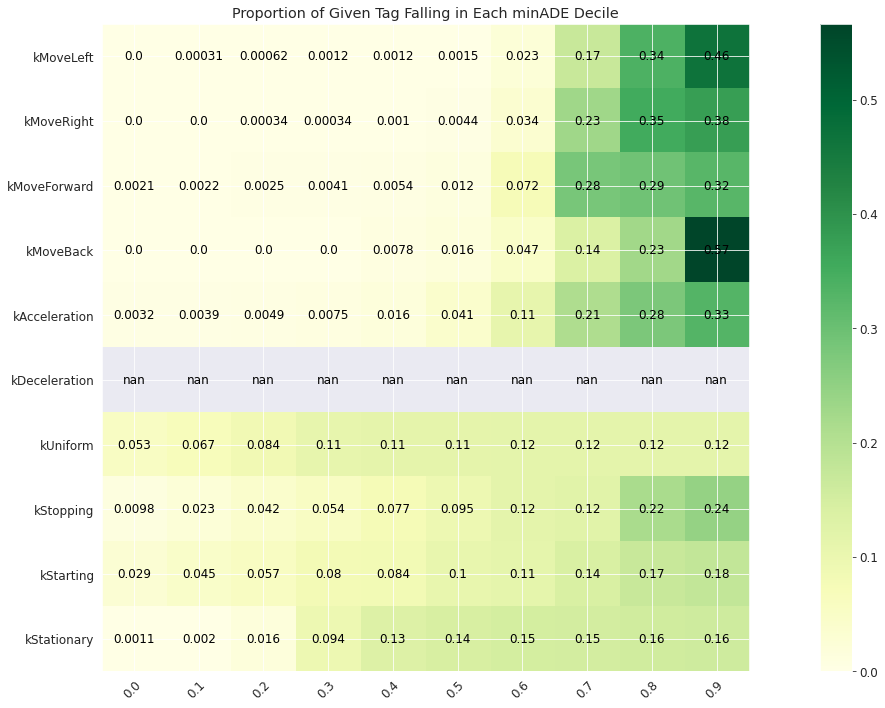

In [43]:
# Example takeaway: the majority of instances of the kMoveBack tag (a challenging trajectory type)
# occurs in the decile of predictions with the worst (highest) minADE
tag_heatmap('minADE', TRAJECTORY_TAGS, dataset_key='ood__validation', n_buckets=10, bucket_normalize=False)

### Trajectory Tag Plots
Note that trajectory tags are not mutually exclusive. We report a metric of choice when fixing a given tag (e.g., `kMoveBack`) to be present or absent.

In [44]:
chosen_metric = 'minADE'

In [46]:
import numpy as np
from collections import defaultdict

dataset_keys = list(set(merged_df['dataset_key_y']))

data = defaultdict(list)
for dataset_key in dataset_keys:
    print('\n')
    print('Computing statistics for dataset', dataset_key)
    dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
    for traj_tag in TRAJECTORY_TAGS:
        n_present_absent = []
        for toggle in [1, 0]:
            traj_tag_df = dataset_df[dataset_df[traj_tag] == toggle]
            perc = np.round(100 * (len(traj_tag_df) / len(dataset_df)))
            n_present_absent.append(len(traj_tag_df))
            data['dataset'].append(dataset_key)
            data['traj_tag'].append(f'{traj_tag}__{str(toggle)}')
            data['val'].append(traj_tag_df[chosen_metric].mean())
            
        print(f'{traj_tag}: Present {n_present_absent[0]} | Absent {n_present_absent[1]}')



Computing statistics for dataset moscow__validation
kMoveLeft: Present 10127 | Absent 399625
kMoveRight: Present 13398 | Absent 396354
kMoveForward: Present 163478 | Absent 246274
kMoveBack: Present 1539 | Absent 408213
kAcceleration: Present 119816 | Absent 289936
kDeceleration: Present 0 | Absent 409752
kUniform: Present 331303 | Absent 78449
kStopping: Present 22760 | Absent 386992
kStarting: Present 33394 | Absent 376358
kStationary: Present 178064 | Absent 231688


Computing statistics for dataset ood__validation
kMoveLeft: Present 3246 | Absent 52423
kMoveRight: Present 2978 | Absent 52691
kMoveForward: Present 9513 | Absent 46156
kMoveBack: Present 256 | Absent 55413
kAcceleration: Present 11131 | Absent 44538
kDeceleration: Present 0 | Absent 55669
kUniform: Present 48354 | Absent 7315
kStopping: Present 2132 | Absent 53537
kStarting: Present 2884 | Absent 52785
kStationary: Present 33983 | Absent 21686


<Figure size 1440x720 with 0 Axes>

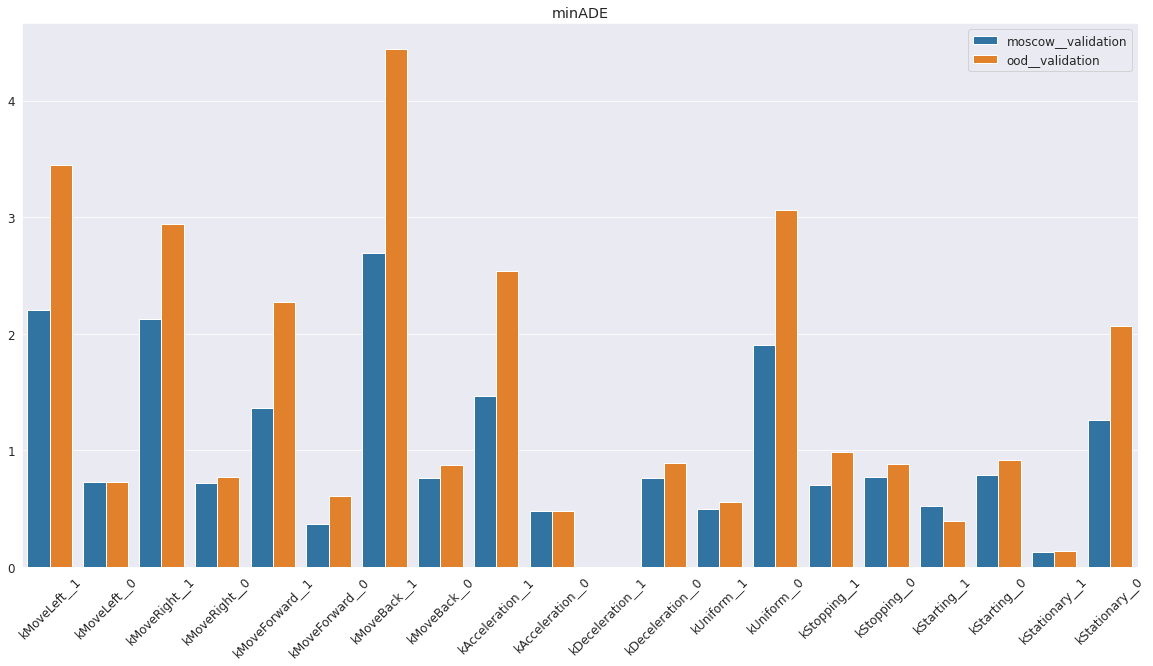

<Figure size 1440x720 with 0 Axes>

In [47]:
plt.xticks(rotation=45)
plt.title(chosen_metric)
ax = sns.barplot(x="traj_tag", y="val", hue="dataset", data=data)
plt.figure(figsize=(20,10))

## Mutually Exclusive Bar Groupings

In [48]:
def plot_mutually_exclusive_bar_groupings(metric, groups):
    data = defaultdict(list)
    for dataset_key in dataset_keys:
        print('Computing statistics for dataset', dataset_key)
        dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
        for group in groups:
            print(group)
            filt_df = dataset_df[dataset_df[group] == True]
            perc = np.round(100 * (len(filt_df) / len(dataset_df)))
            data['dataset'].append(dataset_key)
            data['group'].append(group)
            data['val'].append(filt_df[metric].mean())
            
    plt.title(metric)
    ax = sns.barplot(x="group", y="val", hue="dataset", data=data)
    plt.figure(figsize=(20,10))
    
metric = 'minADE'

### Times of Day

Computing statistics for dataset moscow__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset ood__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening


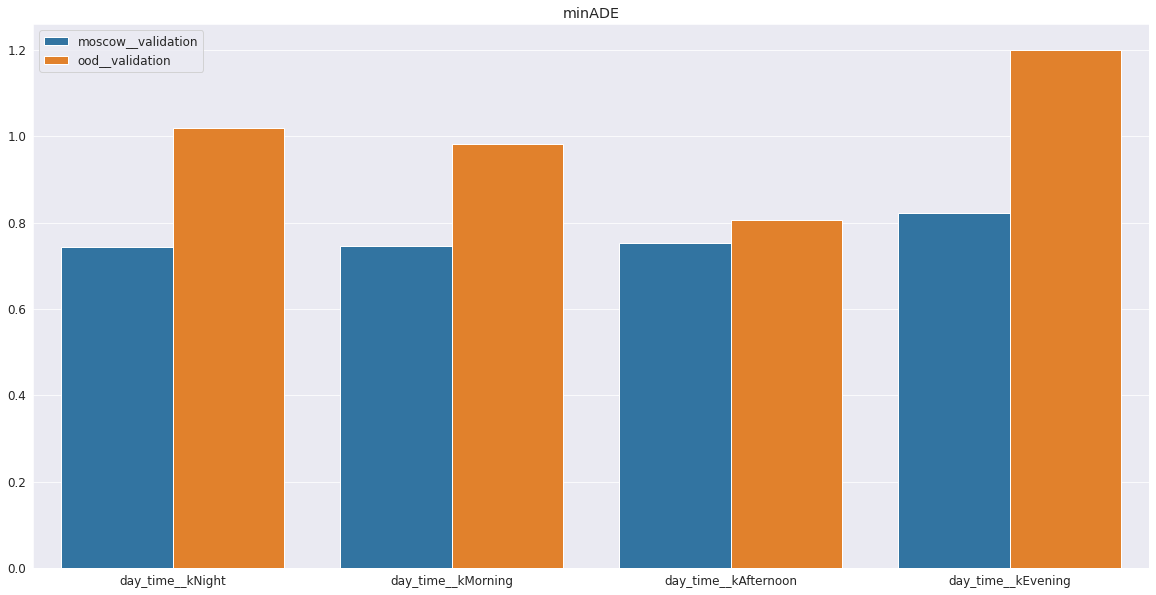

<Figure size 1440x720 with 0 Axes>

In [49]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=TIMES_OF_DAY)

### Seasons

Computing statistics for dataset moscow__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset ood__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn


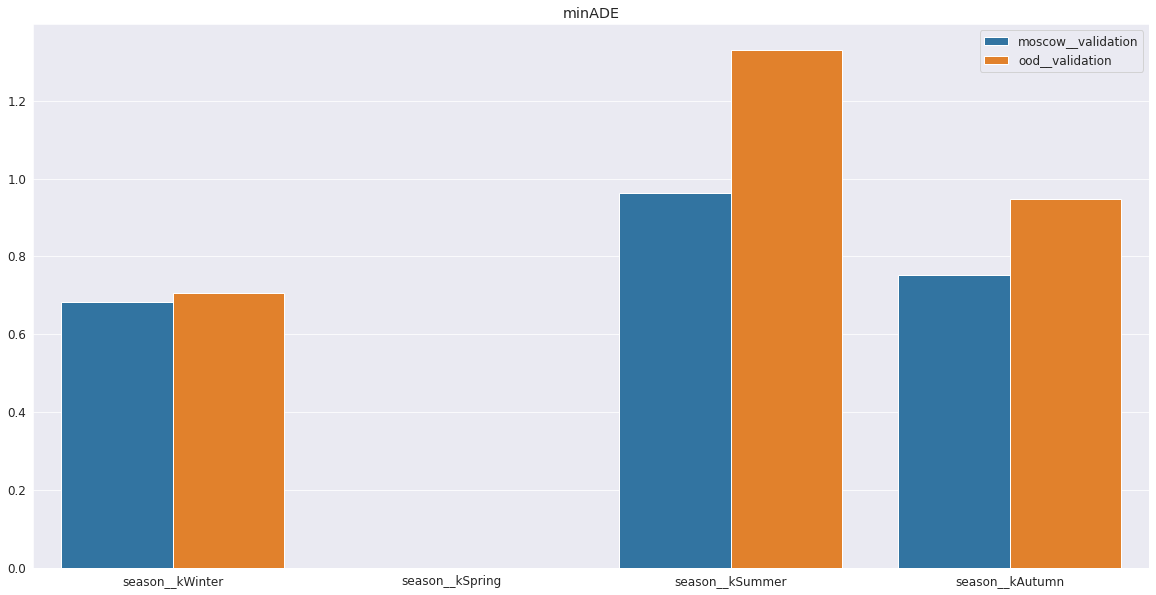

<Figure size 1440x720 with 0 Axes>

In [50]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=SEASONS)

### City

Computing statistics for dataset moscow__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset ood__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv


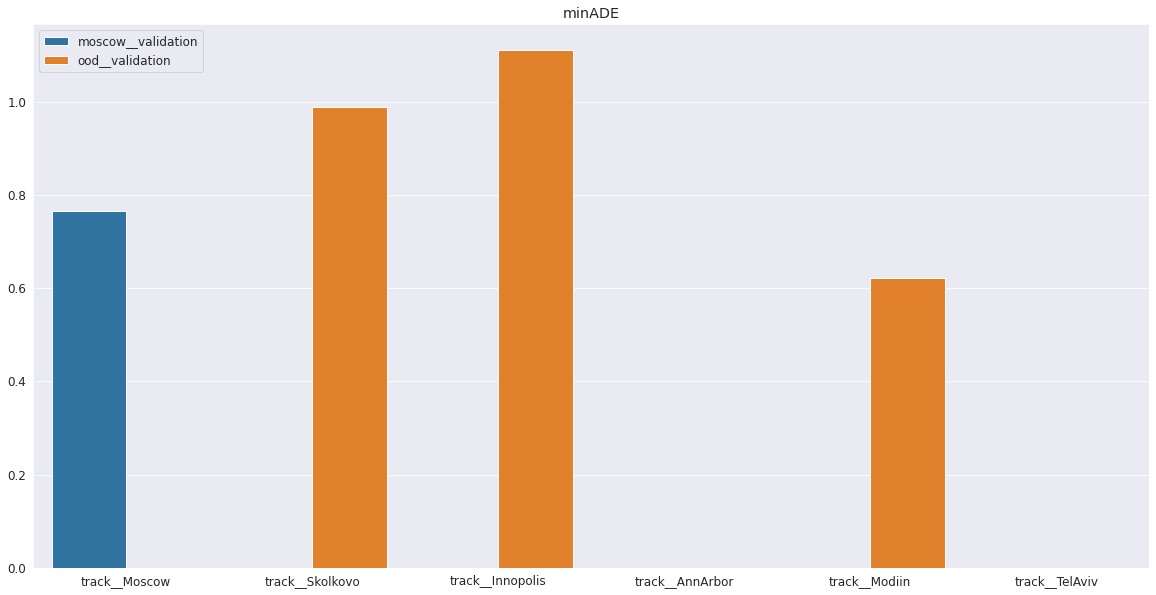

<Figure size 1440x720 with 0 Axes>

In [51]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=CITY)

### Precipitation

Computing statistics for dataset moscow__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset ood__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow


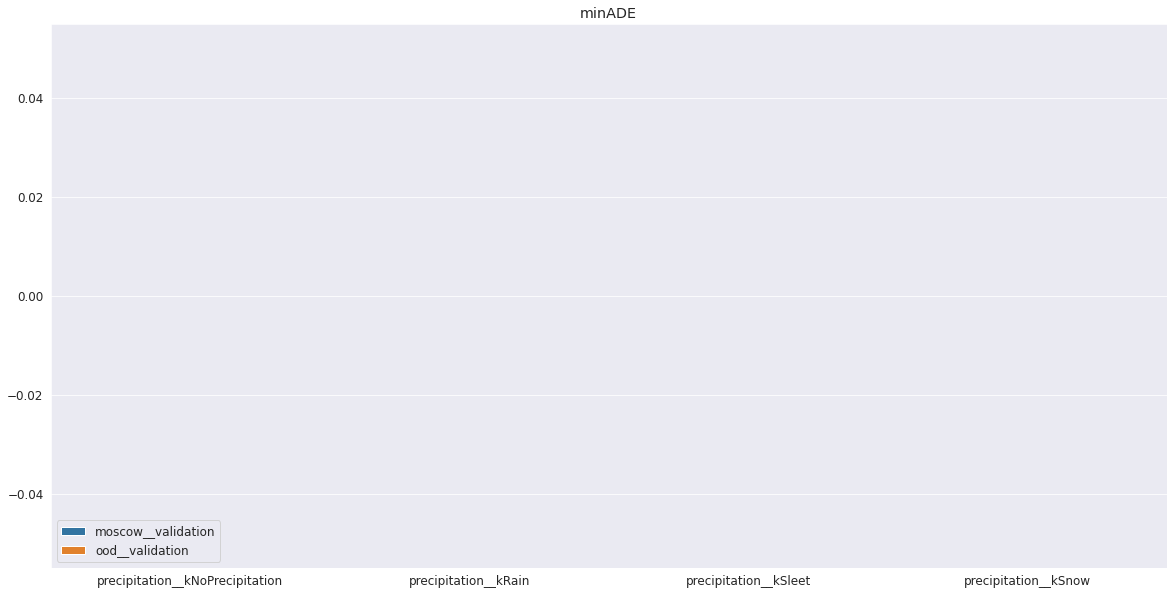

<Figure size 1440x720 with 0 Axes>

In [52]:
PRECIPITATION = [
 'precipitation__kNoPrecipitation',
 'precipitation__kRain',
 'precipitation__kSleet',
 'precipitation__kSnow',
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=PRECIPITATION)

## Confidence Quality

In [53]:
# Compute correlation of avg/minADE wrt confidence, stratified by trajectory tag
metric = 'avgADE'

for dataset_key in dataset_keys:
    for trajectory_tag in TRAJECTORY_TAGS:
        dataset_df = merged_df[(
            merged_df['dataset_key_y'] == dataset_key) &
            (merged_df[trajectory_tag] == True)]
        corr_df = dataset_df[['pred_request_confidence_scores', metric]]
        print('-----')
        print(dataset_key, trajectory_tag)
        print(corr_df.corr(method='pearson'))

-----
moscow__validation kMoveLeft
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.040338
avgADE                                               -0.040338  1.000000
-----
moscow__validation kMoveRight
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.051171
avgADE                                               -0.051171  1.000000
-----
moscow__validation kMoveForward
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.033543
avgADE                                               -0.033543  1.000000
-----
moscow__validation kMoveBack
                                pred_request_confidence_scores  avgADE
pred_request_confidence_scores                          1.0000 -0.0552
avgADE                                                 -0